# Optimization
* How to find optimal elements from set of candidates
* Usually stated as finding min or max of function in given domain
- __Problem Classification__
- __Univariate Optimization__
- __Multivariate Optimization (Unconstrained)__
- __Nonlinear Least Square Problems__
- __Constrained Optimization__
- __Linear Programming__

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import sympy
from scipy import optimize     # nonlinear optimization
import cvxopt                  # convex optimization

[cvxopt library](http://stanford.edu/~boyd/cvxbook)

In [4]:
sympy.init_printing()

In [5]:
from __future__ import division

### Problem Classification
* Description:
    * minimization of f(x)
    * subject to m sets of equality constraints g(x)=0
    * subject to p sets of inequality constraints h(x)<=0
* General formulation == no good solver methods
* Some methods available for special cases
* *linear programming* problem: if f(x) & constraints are linear.
* *convex* nonlinear problems: only one global minimum
![pic](https://github.com/bjpcjp/Numeric-Python/blob/master/pics/convex-vs-nonconvex.png?raw=1)

### Univariate optimization
* Bracketing & Newton's method can be applied
* __golden section search__: used in SciPy.optimize __golden()__. Relatively safe, but slow convergence.
* SciPy.optimize __brent()__: a hybrid of golden & Newton's
* General-purpose: __minimize_scalar()__ with method="golden","brent" or "bounded"

In [5]:
# example problem: minimize area of cylinder with unit volume
# r = radius, h = height, f(r,h) = 2*pi*r^2 + 2*pi*r*h
# 2D optimization problem with an equality constraint

r, h = sympy.symbols("r, h")

In [6]:
Area   = 2*sympy.pi*r**2 + 2*sympy.pi*r*h
Volume =                     sympy.pi*r**2*h

In [7]:
h_r = sympy.solve(Volume - 1)[0]

In [8]:
Area_r = Area.subs(h_r)

In [9]:
rsol = sympy.solve(Area_r.diff(r))[0]
rsol

  2/3  
 2     
───────
  3 ___
2⋅╲╱ π 

In [10]:
_.evalf()

0.541926070139289

* Now verify 2nd derivative is positive and that __rsol__ corresponds to a minimum.

In [11]:
Area_r.diff(r, 2).subs(r, rsol)

12⋅π

In [ ]:
Area_r.subs(r, rsol)

In [ ]:
_.evalf()

### Solve numerically
* Typically required for more realistic problems.

In [12]:
# define an objective function
def f(r):
    return 2 * np.pi * r**2 + 2 / r

In [20]:
# solve using optimize.brent()
r_min = optimize.brent(f, brack=(0.1, 4))
r_min, f(r_min)
#help(optimize.brent)

(0.5419260772557135, 5.535810445932086)

In [18]:
print(dir(optimize.brent))


['__annotations__', '__builtins__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__getstate__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


* Instead of calling __optimize.brent()__ directly, can use generic interface __optimize.minimize_scalar()__. Use __bracket__ to specify a starting interval.

In [19]:
# radius that minimizes cylinder area ~ 0.54;
# corresponding min area ~ 5.54
optimize.minimize_scalar(f, bracket=(0.1, 5))

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 5.535810445932086
       x: 0.5419260648976671
     nit: 13
    nfev: 16

In [21]:
help(optimize.minimize_scalar)

Help on function minimize_scalar in module scipy.optimize._minimize:

minimize_scalar(fun, bracket=None, bounds=None, args=(), method=None, tol=None, options=None)
    Local minimization of scalar function of one variable.
    
    Parameters
    ----------
    fun : callable
        Objective function.
        Scalar function, must return a scalar.
    bracket : sequence, optional
        For methods 'brent' and 'golden', `bracket` defines the bracketing
        interval and is required.
        Either a triple ``(xa, xb, xc)`` satisfying ``xa < xb < xc`` and
        ``func(xb) < func(xa) and  func(xb) < func(xc)``, or a pair
        ``(xa, xb)`` to be used as initial points for a downhill bracket search
        (see `scipy.optimize.bracket`).
        The minimizer ``res.x`` will not necessarily satisfy
        ``xa <= res.x <= xb``.
    bounds : sequence, optional
        For method 'bounded', `bounds` is mandatory and must have two finite
        items corresponding to the optimizat

* Graph optimization across a range of r:

In [22]:
r = np.linspace(0, 2, 100)

<ipython-input-12-a788957b1e86>:3: RuntimeWarning: divide by zero encountered in divide
  return 2 * np.pi * r**2 + 2 / r


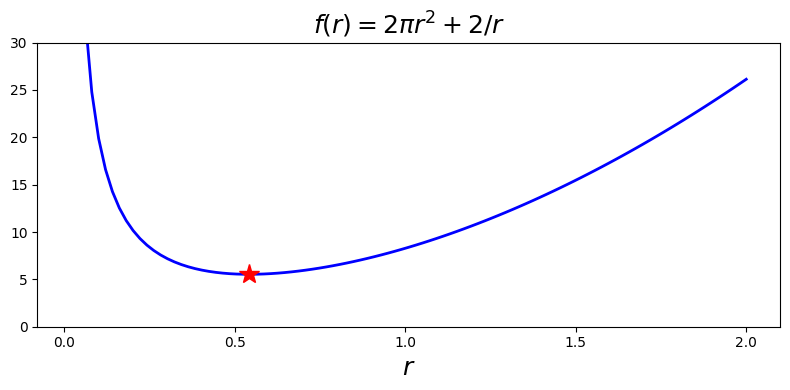

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(r, f(r), lw=2, color='b')
ax.plot(r_min, f(r_min), 'r*', markersize=15)
ax.set_title(r"$f(r) = 2\pi r^2+2/r$", fontsize=18)
ax.set_xlabel(r"$r$", fontsize=18)
ax.set_xticks([0, 0.5, 1, 1.5, 2])
ax.set_ylim(0, 30)

fig.tight_layout()
fig.savefig('ch6-univariate-optimization-example.pdf')

### Unconstrained Multivariate Optimization
* Much harder. Analytical & bracketing schemes are rarely feasible.
* Instead consider using __gradient descent__ method.
* Guaranteed to converge on a minimum, but show & prone to overshoot (ie, "zigzag").
* Newton's method can help. Can be viewed as local approximation of the function. Requires finding both the gradient & Hessian of the function.
* SciPy: Newton's implemented with __optimize.fmin_ncg()__.

In [24]:
x1, x2 = sympy.symbols("x_1, x_2")

In [25]:
# objective function
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2

In [37]:
# gradient
fprime_sym = [f_sym.diff(x_)
              for x_ in (x1, x2)]
print(fprime_sym)

sympy.Matrix(fprime_sym)

[-2*x_2 + 4*(x_1 - 1)**3, -2*x_1 + 10*x_2 - 10]


⎡                  3⎤
⎢-2⋅x₂ + 4⋅(x₁ - 1) ⎥
⎢                   ⎥
⎣-2⋅x₁ + 10⋅x₂ - 10 ⎦

In [27]:
# hessian
fhess_sym = [
    [f_sym.diff(x1_, x2_) for x1_ in (x1, x2)]
    for x2_ in (x1, x2)]

sympy.Matrix(fhess_sym)

⎡           2    ⎤
⎢12⋅(x₁ - 1)   -2⎥
⎢                ⎥
⎣     -2       10⎦

In [38]:
# use symbolic expressions to create vectorized functions for them
f_lmbda      = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda  = sympy.lambdify((x1, x2), fhess_sym, 'numpy')
print(f_lmbda,fprime_lmbda,fhess_lmbda)

<function _lambdifygenerated at 0x7ec32bbd6d40> <function _lambdifygenerated at 0x7ec32bbd4ae0> <function _lambdifygenerated at 0x7ec32bbd7ec0>


In [44]:
# funcs returned by sympy.lambdify take one arg for each var
# SciPy optimization func expect a vectorized function.
# need a wrapper.

def func_XY_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]),dtype=int)

In [45]:
f      = func_XY_X_Y(f_lmbda)
fprime = func_XY_X_Y(fprime_lmbda)
fhess  = func_XY_X_Y(fhess_lmbda)

In [46]:
# optimize using (0,0) as a starting point
X_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [34]:
X_opt # minimum x1,x2

NameError: name 'X_opt' is not defined

* Below: visualize the objective function and solution, using a contour plot.

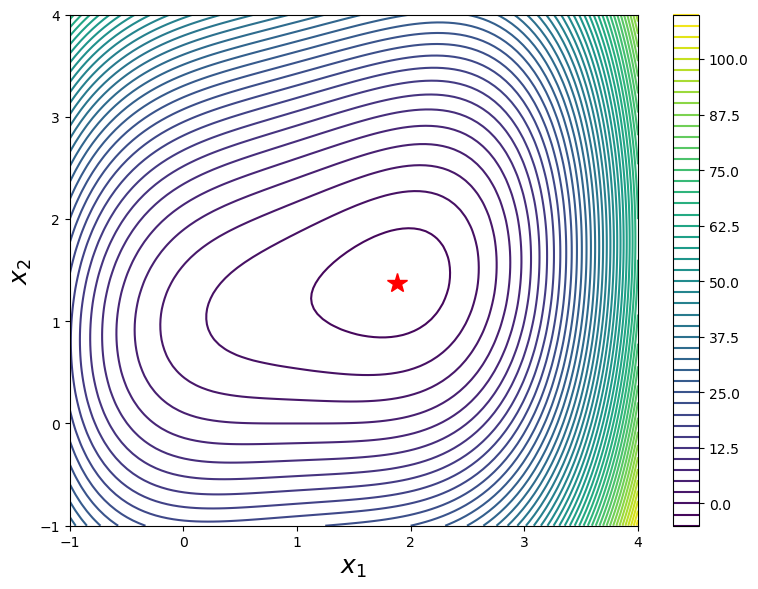

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(X_opt[0], X_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()
fig.savefig('ch6-examaple-two-dim.pdf');

* Not always possible to provide functions for gradients & Hessians. Sometimes better to estimate them.
* __BFGS (optimize.fmin_bfgs())__ and __conjugate-gradient (optimize.fmin_cg())__ methods help here.
* Rule of thumb: BFGS still a good starting point

### Brute force search for initial point
* Suitable when problem space has *many* local minima

In [1]:
# objective function
def f(X):
    x, y = X
    return (4*np.sin(np.pi*x) + 6*np.sin(np.pi*y)) + (x-1)**2 + (y-1)**2

In [6]:
# brute-force search:
# slice objects == coordinate grid search space
# finish=None == auto-refine best candidate

x_start = optimize.brute(f,
                         (slice(-3, 5, 0.5),
                          slice(-3, 5, 0.5)),
                         finish=None)
x_start, f(x_start)

(array([1.5, 1.5]), -9.5)

In [7]:
# we now have good starting point for interative solver like BFGS
x_opt = optimize.fmin_bfgs(f, x_start)

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 21
         Gradient evaluations: 7


In [8]:
x_opt, f(x_opt)

(array([1.47586906, 1.48365787]), -9.520229273055016)

In [9]:
# visualize solution
# need wrapper to shuffle params

def func_X_Y_to_XY(f, X, Y):
    s = np.shape(X)
    return f(
        np.vstack(
            [X.ravel(), Y.ravel()])).reshape(*s)

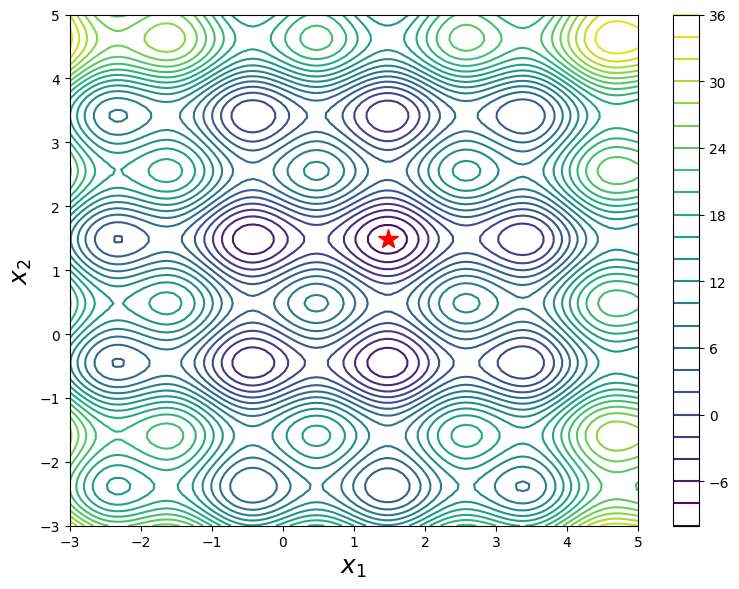

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
fig.tight_layout()
fig.savefig('ch6-example-2d-many-minima.pdf');

### Nonlinear least square problems
* Most popular solver method: __Levenberg-Marquardt__
* SciPy's __optimize.leastsq()__ uses Levenberg-Marquardt.

In [11]:
def f(x, beta0, beta1, beta2):
    return beta0 + beta1 * np.exp(-beta2 * x**2)

In [12]:
beta = (0.25, 0.75, 0.5)

In [13]:
# generate random datapoints
xdata = np.linspace(0, 5, 50)
y = f(xdata, *beta) #*beta是
ydata = y + 0.05 * np.random.randn(len(xdata))

In [14]:
# start solver by defining function for residuals
def g(beta):
    return ydata - f(xdata, *beta)

In [15]:
# define initial guess for parameter vector
beta_start = (1, 1, 1)
# let leastsq() solve it
beta_opt, beta_cov = optimize.leastsq(g, beta_start)

In [16]:
# results
beta_opt

array([0.26544841, 0.75462579, 0.56576231])

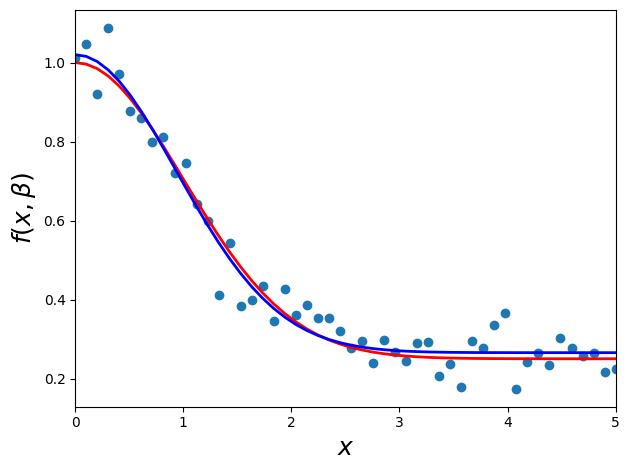

In [17]:
fig, ax = plt.subplots()

ax.scatter(xdata, ydata)
ax.plot(xdata, y, 'r', lw=2)
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2)
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=18)

fig.tight_layout()
fig.savefig('ch6-nonlinear-least-square.pdf')

* alternative method: __curve_fit()__ - convenience wrapper around __leastsq()__; eliminates need to explicitly define residual function for the least square problem.

In [18]:
beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata)
beta_opt

array([0.26544841, 0.75462579, 0.56576231])

## Constrained optimization

* Simple example: optimization with coordinates subject to boundary conditions
* SciPy offers __L-BFGS-B__ method for this use case

In [19]:
# objective function
def f(X):
    x, y = X
    return (x-1)**2 + (y-1)**2

In [20]:
x_opt = optimize.minimize(
    f, (0, 0),
    method='BFGS').x

In [21]:
# boundary constraints
bnd_x1, bnd_x2 = (2, 3), (0, 2)

x_cons_opt = optimize.minimize(
    f, np.array([0, 0]),
    method='L-BFGS-B',
    bounds=[bnd_x1, bnd_x2]).x

* Visualization of the objective function shown below.
* unconstrained minima = blue star
* constrainted minima = red star
* feasible constrained region = gray shading

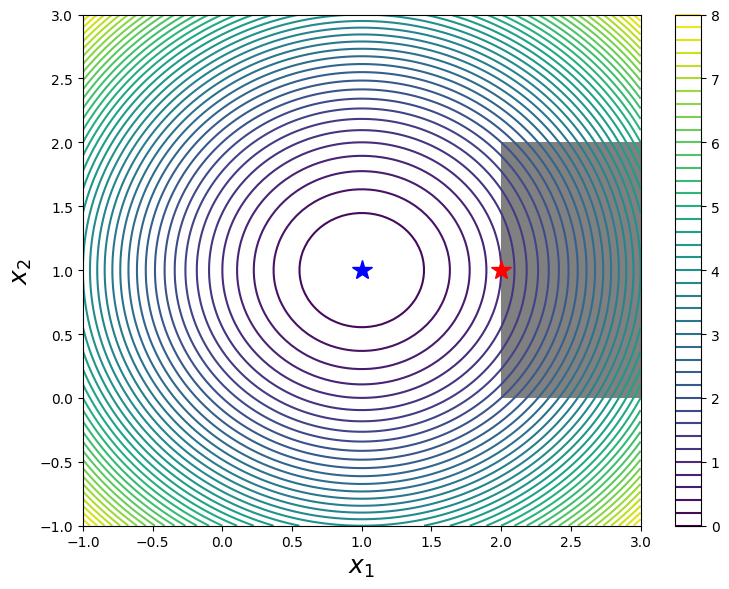

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]),
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
fig.savefig('ch6-example-constraint-bound.pdf');

### Lagrange multipliers
* A technique for converting constrained optimization into unconstrained equivalent by intro'ing more variables.
* Below: maximize volume of rectange of dimensions x1,x2,x3 with constraint that total surface area must be 1.0.

In [23]:
# symbolics first
x = x1, x2, x3, l = sympy.symbols("x_1, x_2, x_3, lambda")

In [24]:
# volume
f = x1*x2*x3

In [25]:
# surface area constraint
g = 2 * (x1*x2 + x2*x3 + x3*x1) - 1

In [26]:
# Lagrangian
L = f + l*g

In [27]:
# Lagrangian gradient
grad_L = [sympy.diff(L, x_)
          for x_ in x]

In [28]:
# solve for zero. should return two points.
# However, 2nd point has x1<0 = not viable use case. (x1 is a dimension)
# so 1st point must be answer.
sols = sympy.solve(grad_L)
sols

⎡⎧   -√6       √6      √6      √6⎫  ⎧   √6      -√6       -√6       -√6 ⎫⎤
⎢⎨λ: ────, x₁: ──, x₂: ──, x₃: ──⎬, ⎨λ: ──, x₁: ────, x₂: ────, x₃: ────⎬⎥
⎣⎩    24       6       6       6 ⎭  ⎩   24       6         6         6  ⎭⎦

In [29]:
# verify by eval'ing constraint func & objective func using answer
g.subs(sols[0]), f.subs(sols[0])

⎛   √6⎞
⎜0, ──⎟
⎝   36⎠

### Inequality constraint solver
* SciPy offers __optimize.slsqp() (sequential least squares programming)__, also available via __optimize.minimize__ with __method='SLSQP'__.

In [30]:
# objective function
def f(X):
    return -X[0] * X[1] * X[2]

# constraint function
def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

In [31]:
constraints = [dict(type='eq', fun=g)] # type = 'eq'

In [32]:
result = optimize.minimize(
    f, [0.5, 1, 1.5],
    method='SLSQP',
    constraints=constraints)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06804136862287297
       x: [ 4.082e-01  4.083e-01  4.083e-01]
     nit: 18
     jac: [-1.667e-01 -1.667e-01 -1.667e-01]
    nfev: 77
    njev: 18

In [33]:
result.x

array([0.40824188, 0.40825127, 0.40825165])

### Inequality constraints
* Done using __type='ineq'__ in a constraint dictionary.
* Below: quadratic problem with inequality constraint.

In [34]:
# objective function
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2
# constraint function
def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4

In [35]:
x_opt = optimize.minimize(
    f, (0, 0), method='BFGS').x

In [36]:
constraints = [dict(type='ineq', fun=g)] # type = 'ineq'

In [37]:
x_cons_opt = optimize.minimize(
    f, (0, 0),
    method='SLSQP',
    constraints=constraints).x

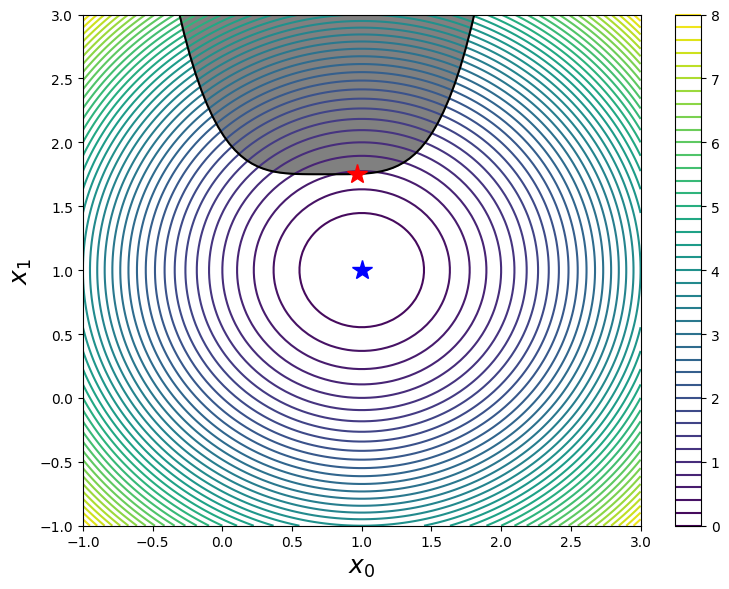

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)

ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color="grey")
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)
plt.colorbar(c, ax=ax)

fig.tight_layout()
fig.savefig('ch6-example-constraint-inequality.pdf');

* Alternative solver: for optimization problems with __only__ inequality constraints.
* Constrained optimization by linear approximation (COBYLA). Implemented by replacing __method='SLSQP'__ with __method='COBYLA'__.

In [43]:
x_cons_opt = optimize.minimize(
    f, (0, 0),
    method='COBYLA',
    constraints=constraints)
print(x_cons_opt)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.5669164196927405
       x: [ 9.687e-01  1.752e+00]
    nfev: 37
   maxcv: 5.721723240603022e-09


### Linear programming
* Much more restricted type of optimization problem.
* Linear objective function
* All constraints are linear equalities/inequalities.
* Can be solved much more efficiently than general nonlinear problems.
* __Simplex__: a popular solver method.
* Let's use the __cvxopt__ library's __solvers.lp__ function.

In [45]:
c = np.array([-1.0, 2.0, -3.0])

A = np.array([[ 1.0, 1.0, 0.0],
              [-1.0, 3.0, 0.0],
              [ 0.0, -1.0, 1.0]])

b = np.array([1.0, 2.0, 3.0])

In [47]:
# cvxopt has unique classes for matrices & vectors - can talk to NumPy
A_ = cvxopt.matrix(A)
b_ = cvxopt.matrix(b)
c_ = cvxopt.matrix(c)
print(A_,b_,c_)

[ 1.00e+00  1.00e+00  0.00e+00]
[-1.00e+00  3.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00  1.00e+00]
 [ 1.00e+00]
[ 2.00e+00]
[ 3.00e+00]
 [-1.00e+00]
[ 2.00e+00]
[-3.00e+00]



In [51]:
sol = cvxopt.solvers.lp(c_, A_, b_); sol

Optimal solution found.


{'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <3x1 matrix, tc='d'>,
 'z': <3x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 0.0,
 'relative gap': 0.0,
 'primal objective': -10.0,
 'dual objective': -10.0,
 'primal infeasibility': 0.0,
 'primal slack': -0.0,
 'dual slack': 0.0,
 'dual infeasibility': 1.4835979218054372e-16,
 'residual as primal infeasibility certificate': None,
 'residual as dual infeasibility certificate': None,
 'iterations': 0}

In [52]:
x = np.array(sol['x']); x

array([[0.25],
       [0.75],
       [3.75]])

In [53]:
sol['primal objective']

-10.0